In [1]:
import os
import matplotlib.pyplot as plt
import cv2

from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, confusion_matrix

import numpy as np 
import pandas as pd 

# Set max number of rows and columns to display
pd.set_option('display.width', 10000)

In [2]:
path = '.\\dataset'
files = os.listdir(path)

def get_label(file):
    parts = file.split('_')
    index = parts[-1].rfind('.')
    value = parts[-1][:index]
    return value 

gather_image = []

for file in files:
    label = get_label(file)
    img_path = os.path.join(path, file)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image,  cv2.COLOR_BGR2RGB)
    gather_image.append(np.array([label, image], dtype=object))

images = np.stack(gather_image, axis=0)



In [3]:
def kmeans_segmentation(img, n_clusters, random_state=0):
    rows, cols, bands = img.shape
    X = img.reshape(-1, bands)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    kmeans.fit(X)
    labels = kmeans.labels_.reshape(rows, cols)
    return labels

def centers(img, label):
    unique_labels = np.unique(label)
    center_channel1 = np.zeros_like(unique_labels, dtype=float)
    center_channel2 = np.zeros_like(unique_labels, dtype=float)
    center_channel3 = np.zeros_like(unique_labels, dtype=float)

    for labels in unique_labels:
        mask = label == labels
        center_channel1[labels] = int(np.mean(img[mask, 0]))
        center_channel2[labels] = int(np.mean(img[mask, 1]))
        center_channel3[labels] = int(np.mean(img[mask, 2]))

    result_matrix = np.zeros_like(img, dtype=float)
    for labels in unique_labels:
        mask = label == labels
        result_matrix[mask, 0] = center_channel1[labels]
        result_matrix[mask, 1] = center_channel2[labels]
        result_matrix[mask, 2] = center_channel3[labels]
    segmentation_img = result_matrix.astype(np.uint8)
    return center_channel1, center_channel2, center_channel3, segmentation_img

def morphological_denoise(im, kernel_open=(3,3), kernel_close=(5,5)):
    
    kernel = np.ones(kernel_open, np.uint8)
    opening = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel) ## Opening

    kernel = np.ones(kernel_close, np.uint8)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    return closing

def coordinates_retacgle(hull, scaling_width, scaling_height):
    convex_Hull = cv2.convexHull(hull)
    x, y, w, h = cv2.boundingRect(convex_Hull)
    x, y = x + w // 2, y + h // 2
    w_new = int((w * scaling_width) // 2)
    h_new = int((h * scaling_height) // 2)
    return x, y, w_new, h_new

# Crop the image using convex hull
def crop_image_hull(image, hull):
  mask_hull = np.zeros_like(image)
  cv2.drawContours(mask_hull, [hull], -1, (255, 255, 255), thickness=cv2.FILLED)
  result = cv2.bitwise_and(image, mask_hull)
  return mask_hull, result

def crop_image_rectangle(image, hull, scaling_width = 0.75, scaling_height = 0.6):
  x, y, w_new, h_new = coordinates_retacgle(hull, scaling_width, scaling_height)
  mask_rec = np.zeros_like(image)
  cv2.rectangle(mask_rec, (x - w_new, y - h_new), (x + w_new, y + h_new), (255, 255, 255),  thickness=cv2.FILLED)
  result = cv2.bitwise_and(image, mask_rec)
  return mask_rec, result


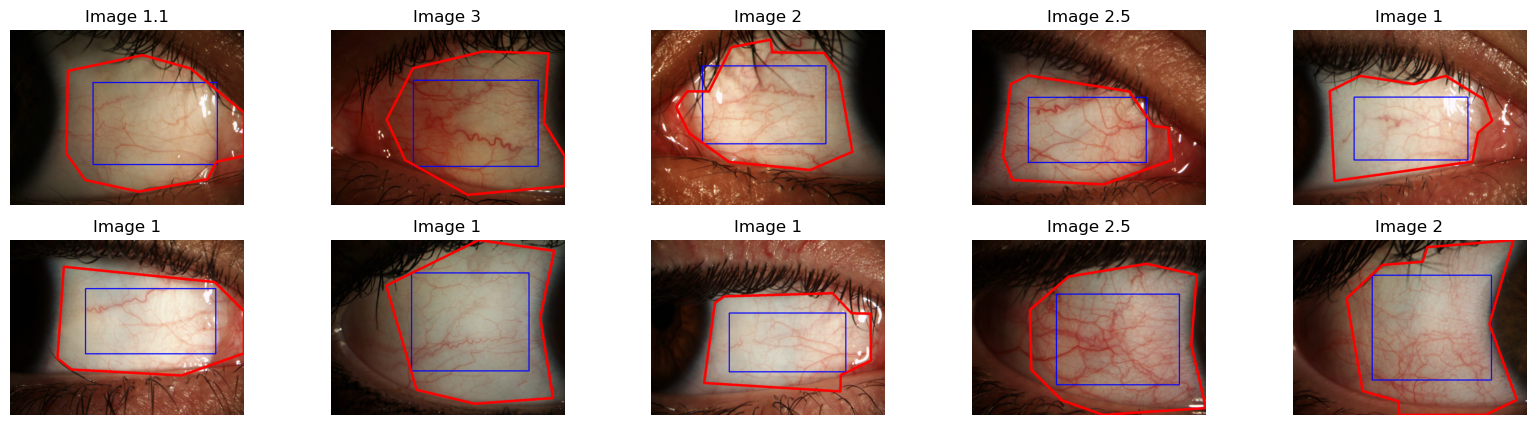

In [4]:

plt.figure(figsize=(20, 5))

# Assuming images is a list of images
for index, image in enumerate(images):
    label_img = image[0]
    img = image[1].copy()

    lab = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2Lab)
    l_channel = lab[:, :, 0]
    l_channel = cv2.GaussianBlur(l_channel, (5, 5), 0)
    lab[:, :, 0] =   l_channel 

    # lab = morphological_denoise(lab, kernel_open=(49, 49), kernel_close=(59, 59))
    lab = morphological_denoise(lab, kernel_open=(39, 39), kernel_close=(49, 49))

    label = kmeans_segmentation(lab, n_clusters=2, random_state=0)
    center_channel1, center_channel2, center_channel3, segmentation_img = centers(lab, label)

    diff = 1
    lowerLimit = np.array([center_channel1[0] - diff, center_channel2[0], center_channel3[0]])
    upperLimit = np.array([center_channel1[0] + diff, center_channel2[0], center_channel3[0]])

    mask = cv2.inRange(segmentation_img, lowerLimit, upperLimit)
    _, mask = cv2.threshold(mask, 100, 1, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    final_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 200000:
            final_contours.append(contour)

    for contour in final_contours:
        epsilon = 0.014 * cv2.arcLength(contour, True)
        hull = cv2.approxPolyDP(contour, epsilon, True)

        x, y, w_new, h_new = coordinates_retacgle(hull, scaling_width = 0.70, scaling_height = 0.6)

        # Draw the rectangle 
        cv2.rectangle(img, (x - w_new, y - h_new), (x + w_new, y + h_new), (0, 0, 255), 4)
        cv2.drawContours(img, [hull], -1, (255, 0, 0), 10)

    # Plot the result for each image
    plt.subplot(2, len(images) // 2, index + 1)
    plt.imshow(img)
    plt.title(f'Image {label_img}')
    plt.axis('off')

plt.show()


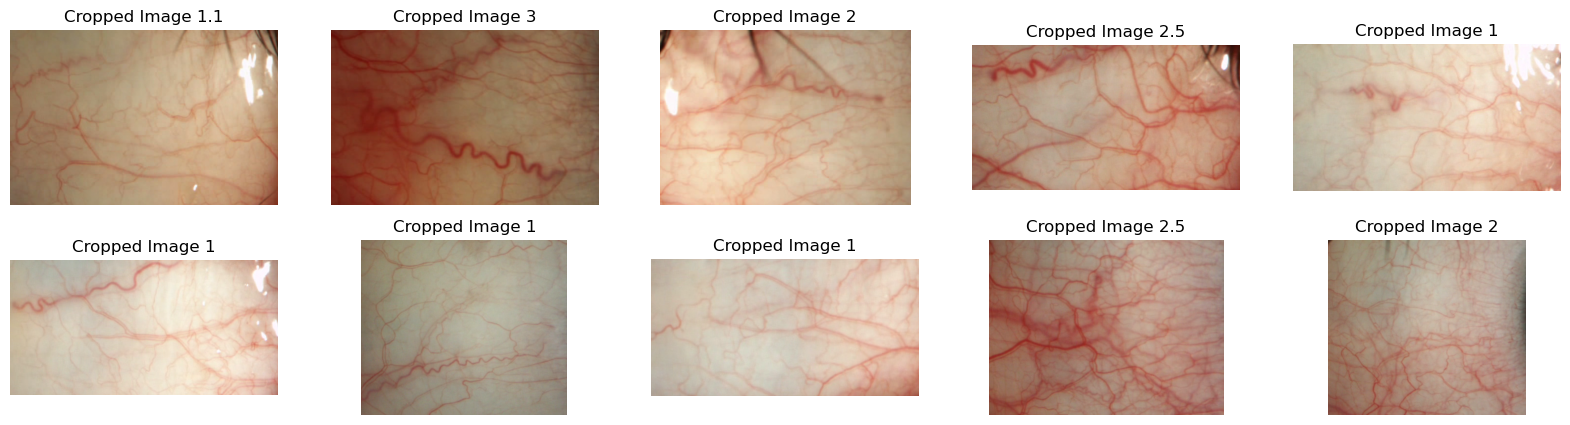

In [5]:
plt.figure(figsize=(20, 5))

cropped_imgs = [] # np.zeros_like(images)

for index, image in enumerate(images):
    label_img = image[0]
    img = image[1].copy()

    lab = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2Lab)
    l_channel = lab[:, :, 0]
    l_channel = cv2.GaussianBlur(l_channel, (5, 5), 0)
    lab[:, :, 0] =   l_channel 

    lab = morphological_denoise(lab, kernel_open=(49, 49), kernel_close=(59, 59))

    label = kmeans_segmentation(lab, n_clusters=2, random_state=0)
    center_channel1, center_channel2, center_channel3, segmentation_img = centers(lab, label)

    diff = 1
    lowerLimit = np.array([center_channel1[0] - diff, center_channel2[0], center_channel3[0]])
    upperLimit = np.array([center_channel1[0] + diff, center_channel2[0], center_channel3[0]])
    # print(lowerLimit, center_channel1[0], upperLimit)

    mask = cv2.inRange(segmentation_img, lowerLimit, upperLimit)
    _, mask = cv2.threshold(mask, 100, 1, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    final_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100000:
            final_contours.append(contour)

    for contour in final_contours:
        epsilon = 0.014 * cv2.arcLength(contour, True)
        hull = cv2.approxPolyDP(contour, epsilon, True)

        # mask_hull, cropped_image = crop_image_hull(img, hull)
        mask_rec, cropped_rec = crop_image_rectangle(img, hull, scaling_width = 0.70, scaling_height = 0.6) 

        non_zero_pixels = np.where(cropped_rec[:, :, 2] > 0)
        x_min, y_min = np.min(non_zero_pixels[1]), np.min(non_zero_pixels[0])
        x_max, y_max = np.max(non_zero_pixels[1]), np.max(non_zero_pixels[0])
        cropped_image = cropped_rec[y_min:y_max + 1, x_min:x_max + 1]

        cropped_imgs.append( np.array([label_img, cropped_image], dtype=object))

        # Plot the cropped image
        plt.subplot(2, len(images) // 2, index + 1)
        plt.imshow(cropped_image)
        plt.title(f'Cropped Image {label_img}')
        plt.axis('off')

plt.show()


In [6]:
def nothing(x):
    pass

# # Load your image
# image = cropped_imgs[8].astype(np.uint8) #  cropped_imgs[1,:,:,:] 
# image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# # Create a window and the trackbars
# cv2.namedWindow('Image')

# cv2.createTrackbar("L - H", "Image", 0, 179, nothing)
# cv2.createTrackbar("L - S", "Image", 0, 255, nothing)
# cv2.createTrackbar("L - V", "Image", 0, 255, nothing)
# cv2.createTrackbar("U - H", "Image", 179, 179, nothing)
# cv2.createTrackbar("U - S", "Image", 255, 255, nothing)
# cv2.createTrackbar("U - V", "Image", 255, 255, nothing)

# while True:
#     # Convert the image to HSV
#     hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#     # Get trackbar positions
#     l_h = cv2.getTrackbarPos("L - H", "Image")
#     l_s = cv2.getTrackbarPos("L - S", "Image")
#     l_v = cv2.getTrackbarPos("L - V", "Image")
#     u_h = cv2.getTrackbarPos("U - H", "Image")
#     u_s = cv2.getTrackbarPos("U - S", "Image")
#     u_v = cv2.getTrackbarPos("U - V", "Image")

#     # Define the lower and upper bounds of the color to be tracked
#     lower_bound = np.array([l_h, l_s, l_v])
#     upper_bound = np.array([u_h, u_s, u_v])

#     # Threshold the image to get only the specified color range
#     mask = cv2.inRange(hsv, lower_bound, upper_bound)

#     # Bitwise-AND mask and original image
#     result = cv2.bitwise_and(image, image, mask=mask)
#     result_s = cv2.bitwise_and(hsv[:,:,1], hsv[:,:,1], mask=mask)

#     result_s_expanded = np.expand_dims(result_s, axis=-1)
#     result_s_expanded = np.repeat(result_s_expanded, 3, axis=-1)
#     stacked = np.hstack((image, result, result_s_expanded))

#     cv2.imshow('Trackbars',cv2.resize(stacked,None,fx=0.8,fy=0.8))

#     k = cv2.waitKey(1) & 0xFF
#     if k == 27:  # Escape key
#         break

# cv2.destroyAllWindows()


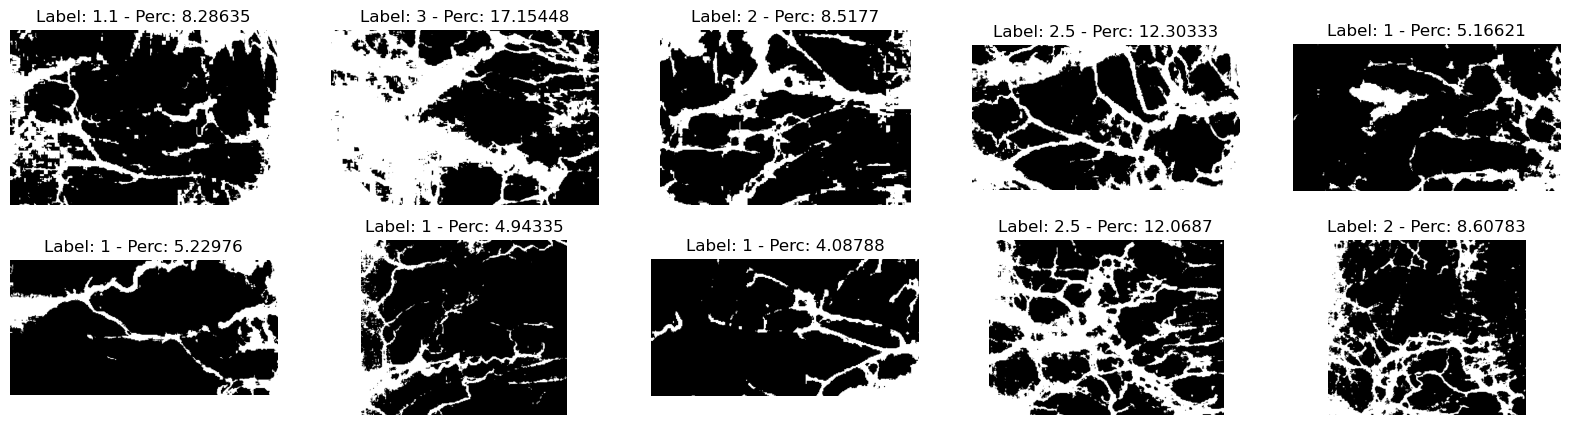

In [7]:
plt.figure(figsize=(20, 5))

assess_performance = []


for index, img in enumerate(cropped_imgs): 
    label_img = img[0]
    img = img[1].copy()
    roi_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    saturation = roi_hsv[:,:,1]
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(3, 3))
    saturation = clahe.apply(saturation)

    red = cv2.inRange(saturation, 130, 255)

    mask = np.where(img > 0, 1.0, 0.0)
    area =  np.count_nonzero(mask)
    count_white = np.count_nonzero(red)
    perc_white = np.round(count_white / area * 100, 5)
    assess_performance.append(np.array([label_img, perc_white], dtype=object))

    plt.subplot(2, 5, index + 1)
    plt.imshow(red, cmap='gray')
    plt.title(f'Label: {label_img} - Perc: {perc_white}')
    plt.axis('off')

plt.show()

In [8]:
def assess_level(x):
    if 0 <= x < 1:
        return "Normal"
    elif 1 <= x < 1.5:
        return "Low_level"
    elif 1.5 <= x < 2.5:
        return "Medium_level"
    elif 2.5 <= x <= 3:
        return "High_level"
    else:
        return "Out_of_range"
    
def remove_label(label_to_remove, labels, predictions):
    bool_labels = [ not (label == label_to_remove) for label in labels]
    new_labels = labels[bool_labels]
    new_predictions = predictions[bool_labels]
    return new_labels, new_predictions

def map_labels_to_binary(labels, positive_label='Low_level'):
    return [1 if label == positive_label else 0 for label in labels]

labels = np.array([assess_level(float(assess_performance[i][0])) for i in range(10)])
predictions = np.array([ float(assess_performance[i][1]) for i in range(10)], dtype=np.float64)

### Low_level versus Medium_level

new_labels, new_predictions = remove_label('High_level', labels, predictions)
labels_cat = map_labels_to_binary(new_labels, positive_label='Medium_level')

print()
print('New Label: ', new_labels)
print('Category Label: ', labels_cat)

print()
print('New prediction: ', np.around(new_predictions, 2))

false_positive, true_positive, threshold = roc_curve(labels_cat, new_predictions)

# Find the optimal threshold
optimal_idx = np.argmax(true_positive - false_positive)
optimal_threshold = threshold[optimal_idx]

print()
print('Specificity: ', 1 - false_positive[optimal_idx],' - ', 'Sensitivity: ', true_positive[optimal_idx])

predicted_labels = (new_predictions >= optimal_threshold).astype(int)
conf_matrix = confusion_matrix(labels_cat, predicted_labels)
auc = ( conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix) 

print()
print("Confusion Matrix:")
print(conf_matrix)

print()
print('accuracy: ', auc)
print('threshold: ', optimal_threshold)





New Label:  ['Low_level' 'Medium_level' 'Low_level' 'Low_level' 'Low_level'
 'Low_level' 'Medium_level']
Category Label:  [0, 1, 0, 0, 0, 0, 1]

New prediction:  [8.29 8.52 5.17 5.23 4.94 4.09 8.61]

Specificity:  1.0  -  Sensitivity:  1.0

Confusion Matrix:
[[5 0]
 [0 2]]

accuracy:  1.0
threshold:  8.5177


In [9]:
labels = np.array([assess_level(float(assess_performance[i][0])) for i in range(10)])
predictions = np.array([ float(assess_performance[i][1]) for i in range(10)], dtype=np.float64)

### Medium_level versus High_level

new_labels, new_predictions = remove_label('Low_level', labels, predictions)
labels_cat = map_labels_to_binary(new_labels, positive_label='High_level')

print()
print('New Label: ', new_labels)
print('Category Label: ', labels_cat)

print()
print('New prediction: ', np.around(new_predictions, 2))

false_positive, true_positive, threshold = roc_curve(labels_cat, new_predictions)

# Find the optimal threshold
optimal_idx = np.argmax(true_positive - false_positive)
optimal_threshold = threshold[optimal_idx]

print()
print('Specificity: ', 1 - false_positive[optimal_idx], ' - ', 'Sensitivity: ', true_positive[optimal_idx])

predicted_labels = (new_predictions >= optimal_threshold).astype(int)
conf_matrix = confusion_matrix(labels_cat, predicted_labels)
auc = ( conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix) 

print()
print("Confusion Matrix:")
print(conf_matrix)

print()
print('accuracy: ', auc)
print('threshold: ', optimal_threshold)



New Label:  ['High_level' 'Medium_level' 'High_level' 'High_level' 'Medium_level']
Category Label:  [1, 0, 1, 1, 0]

New prediction:  [17.15  8.52 12.3  12.07  8.61]

Specificity:  1.0  -  Sensitivity:  1.0

Confusion Matrix:
[[2 0]
 [0 3]]

accuracy:  1.0
threshold:  12.0687
